<a href="https://www.kaggle.com/code/aleksandrmorozov123/video-object-detection?scriptVersionId=198784248" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-detection-image-dataset/Sample_Video_HighQuality.mp4
/kaggle/input/vehicle-detection-image-dataset/SampleVideo_LowQuality.mp4
/kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/valid/frame_9354_jpg.rf.17a109db9b27f2c8ccf841c86825203d.jpg
/kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/valid/frame_1029_jpg.rf.d578c1ee6bf2ccd09142cb7b273108e9.jpg
/kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/valid/frame_1027_jpg.rf.fa6cad605f1dec6d083e29fd204ebefb.jpg
/kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/valid/frame_7778_jpg.rf.8d35874c3d2b46b2a85283270ff36867.jpg
/kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/valid/frame_3403_jpg.rf.30d0e1ebeda1a2d34985cee7

**Estimating vehicle speed with computer vision**

In [2]:
!pip install ultralytics supervision -q

In [3]:
import numpy as np
import supervision as sv
import cv2

from ultralytics import YOLO

model = YOLO('yolov8s.pt')

VIDEO = "/kaggle/input/vehicle-detection-image-dataset/Sample_Video_HighQuality.mp4"

colors = sv.ColorPalette.from_hex(['#ff0000', '#00ff00', '#0000ff'])
video_info = sv.VideoInfo.from_video_path(VIDEO)
video_info

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 52.5MB/s]


VideoInfo(width=1920, height=1080, fps=24, total_frames=1001)

In [4]:
# extract video frame
generator = sv.get_video_frames_generator(VIDEO)
iterator = iter(generator)

frame = next(iterator)

# save first frame
cv2.imwrite("first_frame.png", frame)

True

In [5]:
polygons = [
  np.array([
    [718, 595],[927, 592],[851, 1062],[42, 1059]
  ]),
  np.array([
    [987, 595],[1199, 595],[1893, 1056],[1015, 1062]
  ])
]    

In [6]:
# initialize our zones

zones = [
    sv.PolygonZone(
        polygon=polygon
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=4,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4
        )
    for index
    in range(len(polygons))
]

def process_frame(frame: np.ndarray, i) -> np.ndarray:
    results = model(frame, imgsz=1280, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)
        frame = zone_annotator.annotate(scene=frame)

    return frame

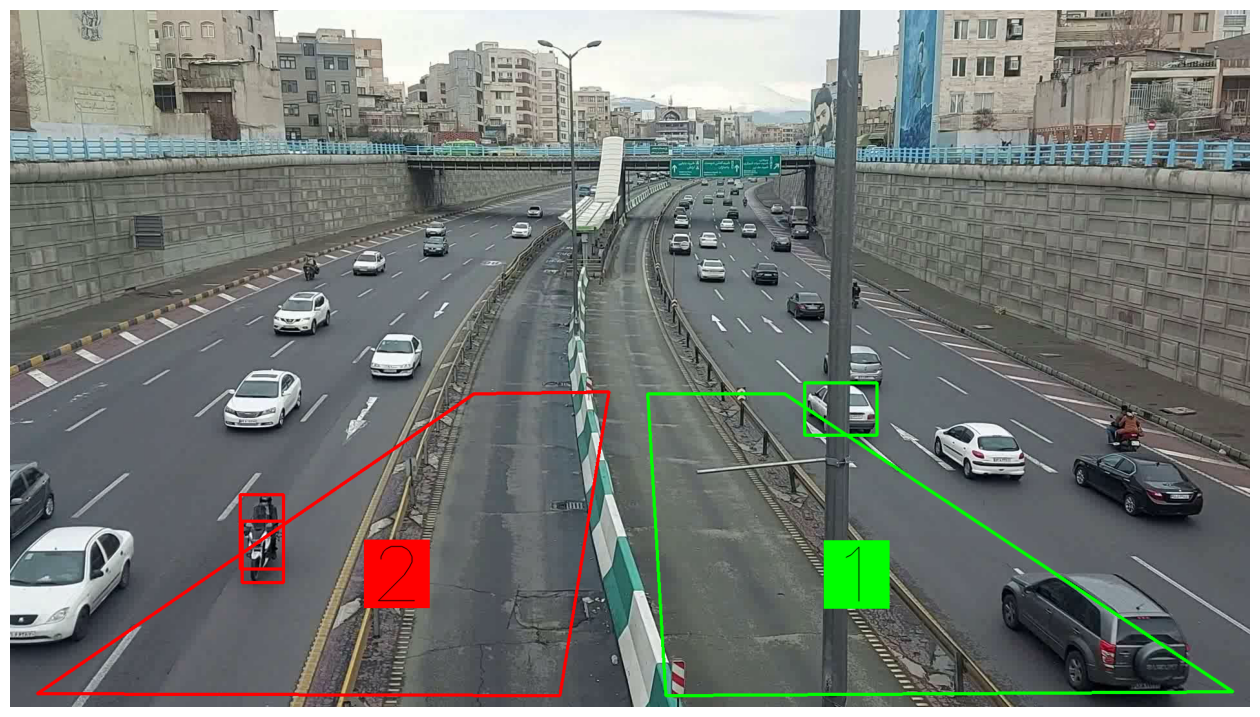

In [7]:
results = model(frame, imgsz=1280, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
    frame = zone_annotator.annotate(scene=frame)

sv.plot_image(frame, (16, 16))